# Example on Transfer Learning 1: Feature Extraction
In this example, we are still do image classifications on the **Dogs vs Cats** small dataset, containing 2,000 images for training, 1,000 for validation and 1,000 for testing.

To address the small dataset problem, a more refined approach would be to leverage a CNN model pre-trained on a large dataset. Such a model would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

There are two ways of transfer learning in training CNNs:
1. feature extraction
2. fine-tuning

In this example, we will try the first way: **feature extraction**.

## Setting-Up 1: Mount Google Drive to the notebook
You can easily load data from Google Drive by mounting it to the notebook with the following code.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting-Up 2: One click to enable FREE GPU
Don't forget to enable GPU in your Colab notebook before training your model.

In Google Colab, it is very easy to do so.

From task bar, click: Runtime ⇨ Change runtime type

Choose 'GPU' in the Hardware accelerator.

## Dataset

Before you start this notebook, make sure the small dataset `dogs-vs-cats-small/`, which was generated in `dogs_vs_cats.ipynb`, is saved in your Google Drive. We will not repeat the "Downloading data ==> Creating small dataset" process in this notebook.

In [3]:
import os
gdrive_dir = '/content/drive/MyDrive/Colab Notebooks'
base_dir = gdrive_dir+'/data/dogs-vs-cats-small'#change here to the small dataset path in your drive
if not os.path.exists(base_dir):
  print(base_dir +' does not exist.')

train_dir = os.path.join(base_dir,'train')
val_dir   = os.path.join(base_dir,'val')
test_dir  = os.path.join(base_dir,'test')
if not os.path.exists(train_dir):
  print(train_dir +' does not exist.')
if not os.path.exists(val_dir):
  print(val_dir +' does not exist.')
if not os.path.exists(test_dir):
  print(test_dir +' does not exist.')

n_train_per_class = 1000
n_val_per_class = 500
n_test_per_class = 500

## Data preprocessing
Now we need do some pre-processing before feeding the data into the network.

Roughly, the preprocessing consists of following steps.
1. Read the image files, decode them to RGB grids of pixels
2. Rescale the pixel values (integers between 0 and 255) to the [0,1] interval, to enhance training stability of neural networks.
3. Apply data augmentation (not covered in this notebook).

In [10]:
import tensorflow as tf

# Define batch size and image size
batch_size = 32
img_size = (150, 150)

# Load the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # Keep order for correct label mapping
)

# Load the validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # Keep order for correct label mapping
)

# Normalize images (rescale pixel values to [0,1])
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Additional Performance Optimization (Optional)
# Benefit of using AUTOTUNE:
# 1. Loads the next batch while the current batch is being processed
# 2. Reduces data loading bottlenecks
# 3. Improves training speed
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## STEP 1: Build the CNN network based on a pretrained model
We will re-use the VGG16 model pretrained on the large ImageNet dataset. Because the ImageNet class set contains multiple dog and cat classes, our dogs-vs-cats small dataset is very similar to the original dataset where the model was pretrained. Therefore, it is beneficial we reuse the pretrained model as a feature extractor - freezing/re-using the convolutional base of the model and training a classifier on top of it. Actually, we could even freeze the fully connected layers (except the output layer), since the two datasets are very similar. But we'll choose not to, in order to cover more general case where the class set of the new dataset doesn't overlap the class set of the original model.

Now, let's extract features on our dogs and cats images by using the convolutional base of the VGG16 network, trained on ImageNet, and then train a dogs-vs-cats classifier on top of these features.

In [11]:
from tensorflow.keras.applications import VGG16

# build the convolutional base of VGG16 network
model_VGG16 = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150,150,3))
model_VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

You must see the final feature map has the shape of (4,4,512). That means the features we will feed into our own fully connected layer will be a 8192-d vector, after flattening it.

At this point, you can process in two ways:
1. The model we build is a small fully-connected model (or MLP), which treats the 8192-d vector as the input layer. There are two steps. The first step is to extract the features (i.e., 8192-d vector) for each image. We need run this `conv_base` network over the small dataset, store the features as Numpy arrays on disk. The second step is to train a small fully-connected model on top of the stored features. This solution is fast and cheap to run, because it only requires running the convolutional base once for each input image, and the convolutional base is by far the most expensive part of the pipeline. But the drawback is that you can't use the data augmentation provided by Keras.
2. Build a CNN model which extends the `conv_base` by adding `Dense` layers on top, and running the whole network end to end on the input image data. This will allow you to use data augmentation. But it is far more expensive than the first one.

Since the next experiment (fine-tuning) is similar to the second solution, we will get some experience on the first solution here.

As extracting features takes some time to run, it is a good practice to save all the features to `.np` files. Then you only need run once for extracting features.

In [12]:

model_folder = '/content/drive/MyDrive/Colab Notebooks/models'
import os
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
train_features_file = os.path.join(model_folder, 'dogs_cats_small_VGG16_train_features.npy')
train_labels_file = os.path.join(model_folder, 'dogs_cats_small_VGG16_train_labels.npy')
val_features_file = os.path.join(model_folder, 'dogs_cats_small_VGG16_val_features.npy')
val_labels_file = os.path.join(model_folder, 'dogs_cats_small_VGG16_val_labels.npy')

# Check if feature files exist
if os.path.exists(train_features_file) and os.path.exists(val_features_file):
  print("Loading pre-extracted features and lables...")

  train_features = np.load(train_features_file)
  train_labels = np.load(train_labels_file)
  val_features = np.load(val_features_file)
  val_labels = np.load(val_labels_file)
else: # As extracting features takes some time to run, it is a good practice to save all the features
  # Extract features using base_model.predict()
  print("Generate VGG16 features for training data ... ")
  train_features = model_VGG16.predict(train_dataset, verbose=1)  # Training features
  print("Done.")
  print("Generate VGG16 features for validation data ... ")
  val_features  = model_VGG16.predict(val_dataset, verbose=1)  # Validation features
  print("Done.")
  #Extract Labels From Dataset
  train_labels = np.concatenate([y.numpy() for _, y in train_dataset])
  val_labels = np.concatenate([y.numpy() for _, y in val_dataset])

  # Save extracted features and labels
  np.save(train_features_file, train_features)
  np.save(train_labels_file, train_labels)
  np.save(val_features_file, val_features)
  np.save(val_labels_file, val_labels)

print("Train features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)

Generate VGG16 features for training data ... 
63/63 ━━━━━━━━━━━━━━━━━━━━ 490s 8s/step
Done.
Generate VGG16 features for validation data ... 
32/32 ━━━━━━━━━━━━━━━━━━━━ 244s 8s/step
Done.
Train features shape: (2000, 4, 4, 512)
Validation features shape: (1000, 4, 4, 512)


Now we build a 3-layer MLP with the extracted features as input. We also add two Dropout to mitigate the overfitting problem on such a small dataset (without data augmentation).

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten

# Flatten the Features to (num_samples, feature_dim)
train_features = train_features.reshape(train_features.shape[0], -1)
val_features   = val_features.reshape(val_features.shape[0], -1)

model = Sequential([
    Input(shape=(train_features.shape[1],)),  # Input layer with extracted feature dimension
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

## STEP 2: Compile the model and train it

It is a good practice to always save your models after training with model.`save(model_folder+'/dogs_cats_small_VGG16_feature_extract.keras')`.

After training, also plot the loss and accuracy of the model over the training and validation set.

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6930 - loss: 0.8554 - val_accuracy: 0.8550 - val_loss: 0.3149
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8762 - loss: 0.3065 - val_accuracy: 0.8610 - val_loss: 0.2936
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8832 - loss: 0.2584 - val_accuracy: 0.8920 - val_loss: 0.2728
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9040 - loss: 0.2398 - val_accuracy: 0.8990 - val_loss: 0.2419
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9132 - loss: 0.1965 - val_accuracy: 0.8780 - val_loss: 0.2728
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9264 - loss: 0.1879 - val_accuracy: 0.8820 - val_loss: 0.2983
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9222 - loss: 0.1918 - val_accuracy: 0.9020 - val_loss: 0.2397
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9407 - loss: 0.1462 - val_accuracy: 0.9090 - v

Text(0.5, 0, 'epoch')

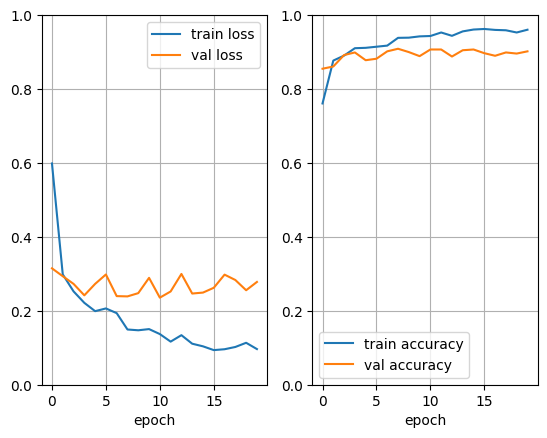

In [14]:
import numpy as np
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(val_features, val_labels))


model_folder = '/content/drive/MyDrive/Colab Notebooks/models'
import os
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
model.save(model_folder+'/dogs_cats_small_VGG16_feature_extract.keras')  # always save your models after training

# plot the learning curves
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

fig.add_subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')


In [17]:
val_loss, val_acc = model.evaluate(val_features, val_labels)
print(f"Validation Accuracy: {val_acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9087 - loss: 0.2751
Validation Accuracy: 0.9020


You see that it takes only a few second to train 20 epochs on GPU. So if no GPU or you are not in a hurry, this example is also feasible to run on CPU.

**Results:** You reach a validation accuracy of around 90% - 15%-18% improvement over the the small CNN trained from scratch. However, the learning curves also indicate overfitting almost from the start - despite we have used dropout with fairly large rate. This is because this feature extraction method doesn't use data augmentation, which is essential for preventing overfitting with small datasets.

